### TODO Recording:

##### Show HuggingFace

- Go to https://huggingface.co/
- Click on Models, Datasets, Spaces, Docs on top and show
- Back to Models, search for t5-small
- Show the model card

##### Show data

- Go to https://github.com/tuetschek/e2e-dataset


##### Colab
- Go to https://colab.research.google.com and show that we are logged in
- Create a new notebook and give it the right name
- Click on the folder icon on the left and upload the data there trainset.csv
- Collapse the left sidebar
- Click on Runtime and show that we are using a GPU
- Now we can start the notebook

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=76bc4789a1509a88a79f5dd8593aa4af2c3e08e7eb662774ab16e1383af9cd19
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import transformers

transformers.__version__

'4.35.2'

Importing required libraries

In [21]:
import torch

import pandas as pd

from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers.optimization import  Adafactor

from rouge_score import rouge_scorer

Loading our dataset specific to NLG
Link for the dataset-https://github.com/tuetschek/e2e-dataset

In [4]:
restaurants_df = pd.read_csv("/content/trainset.csv")

restaurants_df.sample(20)

mr  \
13248  name[Wildwood], eatType[coffee shop], food[Jap...   
1555   name[The Vaults], food[Japanese], priceRange[m...   
39950  name[The Wrestlers], food[Japanese], priceRang...   
5614   name[Blue Spice], food[English], priceRange[mo...   
10694  name[Aromi], eatType[coffee shop], food[Indian...   
7955   name[The Mill], eatType[pub], food[Fast food],...   
33823  name[Browns Cambridge], priceRange[more than £...   
5972   name[The Vaults], eatType[pub], priceRange[mor...   
34943  name[Wildwood], eatType[pub], food[English], p...   
1604   name[The Eagle], priceRange[cheap], customer r...   
2086   name[Zizzi], eatType[coffee shop], priceRange[...   
29594  name[Loch Fyne], eatType[restaurant], food[Eng...   
31434  name[The Eagle], eatType[coffee shop], food[Fr...   
26698  name[Fitzbillies], eatType[coffee shop], food[...   
15475  name[Fitzbillies], priceRange[less than £20], ...   
33654  name[Aromi], eatType[restaurant], food[Italian...   
40150  name[The Phoenix], food[Indian], customer rati...   
38081  name[The Golden Curry], food[Chinese], custome...   
36490  name[The Wrestlers], food[Italian], priceRange...   
22366  name[The Rice Boat], priceRange[£20-25], custo...   

                                                     ref  
13248  A cheap Japanese coffee shop near Ranch, with ...  
1555   There is a moderately priced Japanese restaura...  
39950  if you are looking for a place to eat that is ...  
5614   Serving English food, Blue Spice is by a river...  
10694  Aromi is a coffee shop which provides Indian f...  
7955   The Mill is a riverside pub offering fast, hig...  
33823  Browns Cambridge has low customer satisfaction...  
5972   The Vaults is a pub near Café Adriatic. It has...  
34943  Wildwood is a low-priced pub that may serve Br...  
1604   The Eagle, five star rated has cheap fare in t...  
2086   The coffee shop named Zizzi is kid friendly, h...  
29594  Loch Fyne is a non-kid friendly English restau...  
31434  The French restaurant, The Eagle, is a high pr...  
26698  In the city centre, there is an Italian coffee...  
15475  Fitzbillies is a low-priced restaurant in the ...  
33654  For an Italian restaurant in the Riverside are...  
40150  The Phoenix serves Indian food and has a custo...  
38081  A highly rated place to buy Chinese food is Th...  
36490  The Wrestlers serves expensive Italian food. I...  
22366  The Rice Boat is located near the Rainbow Vege...

Checking the shape of the dataset

In [5]:
restaurants_df.shape

(42061, 2)

Checking one instance of data.
Column's description:
mr – textual meaning representation (MR)
ref – corresponding natural language utterance (human reference)

In [6]:
restaurants_df["mr"][3]

'name[The Mill], eatType[coffee shop], food[French], priceRange[£20-25], area[riverside], near[The Sorrento]'

In [7]:
restaurants_df["ref"][3]

'Located near The Sorrento is a French Theme eatery and coffee shop called The Mill, with a price range at £20-£25 it is in the riverside area.'

In [8]:
restaurants_df["mr"][1101]

'name[Browns Cambridge], food[French], area[riverside], familyFriendly[yes], near[The Sorrento]'

In [9]:
restaurants_df["ref"][1101]

'Browns Cambridge, a kid friendly French food restaurant, is located riverside near The Sorrento.'

We are sampling a fraction of  data from whole dataset in order to have faster training

In [10]:
restaurants_df_sampled = restaurants_df.sample(frac = 0.3)

restaurants_df_sampled.shape

(12618, 2)

Configuring and checking device

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [12]:
tokenizer = T5Tokenizer.from_pretrained("t5-small", legacy=False)

tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5Tokenizer(name_or_path='t5-small', vocab_size=32000, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_4

In [64]:
tokenizer(["very budget-friendly restaurant"])

{'input_ids': [[182, 1487, 18, 4905, 2062, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1]]}

In [65]:
tokens = tokenizer.tokenize("very budget-friendly restaurant")

tokens

['▁very', '▁budget', '-', 'friendly', '▁restaurant']

In [15]:
ids = tokenizer.convert_tokens_to_ids(tokens)

ids

[182, 1487, 18, 15504, 2062]

In [63]:
model = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict = True)

model = model.to(device)

We are generating output from the model without training and output seems to be random.

In [17]:
restaurants_df['mr'][10]

'name[Browns Cambridge], food[Fast food], area[riverside], familyFriendly[no], near[The Sorrento]'

In [30]:
model.eval()

# Batch size 1
input_ids = tokenizer.encode("name[Browns Cambridge], food[Fast food], area[riverside], familyFriendly[no], near[The Sorrento]", return_tensors = "pt")

input_ids

tensor([[  765, 18207,   517,    10,   564,  6306,   279,  3623,    29,     7,
         10096, 13679,   542,  6306,   371,     9,     7,    17,   542, 13679,
           616,  6306,  5927,    49,  1583, 13679,   384, 17701,   120,  6306,
            29,    32, 13679,  1084,  6306,   634,   264,    52,  5320,    32,
           908,     1]])

In [31]:
input_ids = input_ids.to(device)

outputs = model.generate(input_ids, max_new_tokens=50)

outputs

tensor([[    0,  1620, 18207,   517,    10,   564,  6306,   279,  3623,    29,
             7, 10096, 13679,   542,  6306,   371,     9,     7,    17,   542,
         13679,   616,  6306,  5927,    49,  1583, 13679,   384, 17701,   120,
          6306,    29,    32, 13679,  1084,  6306,   634,   264,    52,  5320,
            32,   908,     1]], device='cuda:0')

In [32]:
tokenizer.decode(outputs[0])

'<pad> WebNLG: name[Browns Cambridge], food[Fast food], area[riverside], familyFriendly[no], near[The Sorrento]</s>'

In [22]:
# Define the reference summary and predicted summary
reference_text = "Bibimbap House is a moderately priced restaurant who's main cuisine is English food."
predicted_text = "Bibimbap House is a moderately priced restaurant who's main cuisine is English food."

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)

# Compute ROUGE scores
rouge_scores = scorer.score(reference_text, predicted_text)

# Print ROUGE scores
for metric, scores in rouge_scores.items():
    print(f'{metric}:')
    print(f'  Precision: {scores.precision}')
    print(f'  Recall: {scores.recall}')
    print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0
rouge2:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0
rougeL:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0


In [23]:
# Define the reference summary and predicted summary
reference_text = "Bibimbap House is a moderately priced restaurant who's main cuisine is English food."
predicted_text = "Bibimbap House is a fairly priced restaurant serving English food"

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)

# Compute ROUGE scores
rouge_scores = scorer.score(reference_text, predicted_text)

# Print ROUGE scores
for metric, scores in rouge_scores.items():
    print(f'{metric}:')
    print(f'  Precision: {scores.precision}')
    print(f'  Recall: {scores.recall}')
    print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 0.8
  Recall: 0.5714285714285714
  F1 Score: 0.6666666666666666
rouge2:
  Precision: 0.5555555555555556
  Recall: 0.38461538461538464
  F1 Score: 0.4545454545454546
rougeL:
  Precision: 0.8
  Recall: 0.5714285714285714
  F1 Score: 0.6666666666666666


In [24]:
# Define the reference summary and predicted summary
reference_text = "Bibimbap House is a moderately priced restaurant who's main cuisine is English food."
predicted_text = "House is a restaurant serving French food"

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)

# Compute ROUGE scores
rouge_scores = scorer.score(reference_text, predicted_text)

# Print ROUGE scores
for metric, scores in rouge_scores.items():
    print(f'{metric}:')
    print(f'  Precision: {scores.precision}')
    print(f'  Recall: {scores.recall}')
    print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 0.7142857142857143
  Recall: 0.35714285714285715
  F1 Score: 0.4761904761904762
rouge2:
  Precision: 0.3333333333333333
  Recall: 0.15384615384615385
  F1 Score: 0.21052631578947367
rougeL:
  Precision: 0.7142857142857143
  Recall: 0.35714285714285715
  F1 Score: 0.4761904761904762


Initializing the Adafactor optimizer with parameter values suggested for t5

In [66]:
optimizer = Adafactor(
    model.parameters(),
    lr = 1e-6,
    eps = (1e-30, 1e-3),
    clip_threshold = 1.0,
    decay_rate = -0.8,
    beta1 = None,
    weight_decay = 0.0,
    relative_step = False,
    scale_parameter = False,
    warmup_init = False
)

Splitting data into Training and Validation sets

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(restaurants_df_sampled, test_size = 0.2, random_state = 123)

X_train.shape, X_val.shape

((10094, 2), (2524, 2))

In [27]:
X_val

mr  \
26151  name[The Golden Palace], eatType[coffee shop],...   
15639  name[Travellers Rest Beefeater], priceRange[mo...   
9298   name[Midsummer House], food[Japanese], priceRa...   
7670   name[The Wrestlers], food[Italian], priceRange...   
32250  name[Loch Fyne], eatType[restaurant], food[Fas...   
...                                                  ...   
32339  name[Green Man], food[Italian], priceRange[hig...   
15971  name[The Plough], eatType[pub], food[Japanese]...   
8429   name[Fitzbillies], food[French], priceRange[mo...   
39910  name[Midsummer House], food[French], customer ...   
40247  name[Bibimbap House], food[English], priceRang...   

                                                     ref  
26151  The Golden Palace is a 3-star Caféteria locate...  
15639  In the riverside area near Café Adriatic is Tr...  
9298   Midsummer House restaurant near All Bar One se...  
7670   The Wrestlers is a restaurant for families tha...  
32250  Loch Fyne restaurant is a fast food, family fr...  
...                                                  ...  
32339  Green Man is a family-friendly restaurant spec...  
15971  The Plough is a Japanese pub near Café Rouge t...  
8429   The best selling super- market economic is Fit...  
39910  Near Café Rouge is Midsummer House which serve...  
40247  Serving high priced meals, Bibimbap House is l...  

[2524 rows x 2 columns]

Setting parameters for training

In [38]:
batch_size = 8

num_of_epochs = 10

In [67]:
loss_stats = {
    "train": [],
    "val": []
}

Model training is done

In [68]:
# Sets the module in training mode
model.train()

for epoch in range(0, num_of_epochs + 1):
    print("Running epoch: {}".format(epoch + 1))

    train_running_loss = 0

    num_of_batches = len(X_train) / batch_size

    for i in range(int(num_of_batches)):
        X_train_batch = []
        y_train_batch = []

        batch_df = X_train[i * batch_size: i * batch_size + batch_size]

        for _, row in batch_df.iterrows():
            X_train_row = row["mr"]
            y_train_row = row["ref"]

            X_train_batch.append(X_train_row)
            y_train_batch.append(y_train_row)

        X_train_batch = tokenizer.batch_encode_plus(X_train_batch, padding = True, truncation = True,
                                                    max_length = 256, return_tensors = "pt")["input_ids"]
        y_train_batch = tokenizer.batch_encode_plus(y_train_batch, padding = True, truncation = True,
                                                    max_length = 256, return_tensors = "pt")["input_ids"]

        X_train_batch = X_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        # clear out the gradients of all Variables
        optimizer.zero_grad()

        # Forward propogation
        train_outputs = model(input_ids = X_train_batch, labels = y_train_batch)

        train_loss = train_outputs.loss
        train_loss.backward()

        train_loss_num = train_loss.item()
        train_running_loss += train_loss_num

        #updating the params
        optimizer.step()

    train_loss = train_running_loss / int(num_of_batches)

    # VALIDATION
    with torch.no_grad():
         val_running_loss = 0

         model.eval()
         num_of_batches = len(X_val)/batch_size

         for i in range(int(num_of_batches)):
             X_val_batch = []
             y_val_batch = []

             val_batch_df = X_val[i * batch_size: i * batch_size + batch_size]

             for idx, row in val_batch_df.iterrows():
                 X_val_row = row["mr"]
                 y_val_row = row["ref"]

                 X_val_batch.append(X_val_row)
                 y_val_batch.append(y_val_row)

             X_val_batch = tokenizer.batch_encode_plus(X_val_batch, padding = True, truncation = True,
                                                       max_length = 256, return_tensors = "pt")["input_ids"]
             y_val_batch = tokenizer.batch_encode_plus(y_val_batch, padding = True, truncation = True,
                                                       max_length = 256, return_tensors = "pt")["input_ids"]
             X_val_batch = X_val_batch.to(device)
             y_val_batch = y_val_batch.to(device)

             val_outputs = model(input_ids = X_val_batch, labels = y_val_batch)

             val_loss = val_outputs.loss

             val_loss_num = val_loss.item()
             val_running_loss += val_loss_num

    val_loss = val_running_loss / int(num_of_batches)

    loss_stats["train"].append(train_loss)
    loss_stats["val"].append(val_loss)

    print(f"Epoch {epoch+1:01}: | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}")

Running epoch: 1
Epoch 1: | Train Loss: 4.388 | Val Loss: 2.584
Running epoch: 2
Epoch 2: | Train Loss: 2.252 | Val Loss: 2.014
Running epoch: 3
Epoch 3: | Train Loss: 1.802 | Val Loss: 1.677
Running epoch: 4
Epoch 4: | Train Loss: 1.561 | Val Loss: 1.515
Running epoch: 5
Epoch 5: | Train Loss: 1.430 | Val Loss: 1.410
Running epoch: 6
Epoch 6: | Train Loss: 1.343 | Val Loss: 1.341
Running epoch: 7
Epoch 7: | Train Loss: 1.280 | Val Loss: 1.287
Running epoch: 8
Epoch 8: | Train Loss: 1.235 | Val Loss: 1.246
Running epoch: 9
Epoch 9: | Train Loss: 1.197 | Val Loss: 1.214
Running epoch: 10
Epoch 10: | Train Loss: 1.165 | Val Loss: 1.188
Running epoch: 11
Epoch 11: | Train Loss: 1.139 | Val Loss: 1.164


In [69]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats). \
    reset_index().melt(id_vars = ["index"]). \
    rename(columns = {"index": "epochs"})

train_val_loss_df.head()

epochs variable     value
0       0    train  4.388359
1       1    train  2.252302
2       2    train  1.801845
3       3    train  1.560804
4       4    train  1.430088

In [70]:
train_val_loss_df.tail()

epochs variable     value
17       6      val  1.287142
18       7      val  1.246493
19       8      val  1.214407
20       9      val  1.187951
21      10      val  1.163588

Text(0.5, 1.0, 'Train-Val Loss vs Epoch')

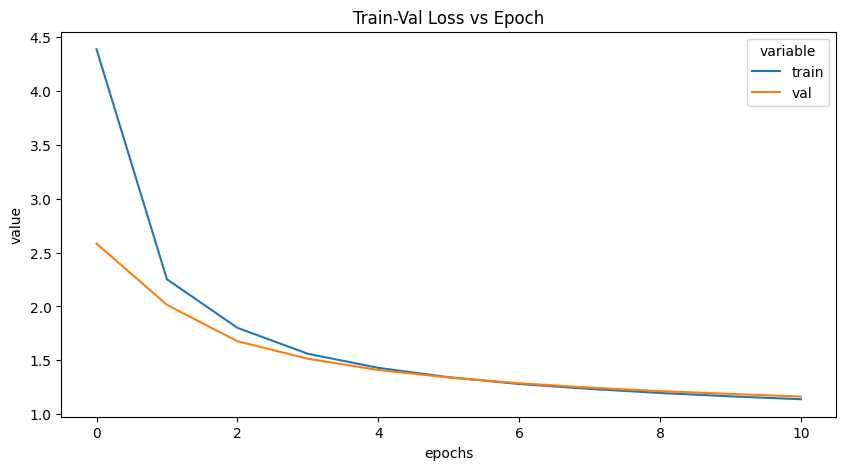

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))

sns.lineplot(data = train_val_loss_df,
             x = "epochs", y = "value",
             hue = "variable"
).set_title("Train-Val Loss vs Epoch")

In [72]:
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [73]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)

In [95]:
X_val.sample(5)

mr  \
31608  name[The Phoenix], food[Indian], customer rati...   
22184  name[The Olive Grove], eatType[pub], food[Fast...   
7990   name[Cotto], priceRange[high], area[riverside]...   
38987  name[Loch Fyne], eatType[restaurant], food[Ita...   
18146  name[Alimentum], food[Fast food], priceRange[m...   

                                                     ref  
31608  Situated on the riverside is The Phoenix. The ...  
22184  There is a cheap pub that provides fast food c...  
7990   Cotto is a high priced place in the riverside ...  
38987  Loch Fyne is an Italian restaurant that is not...  
18146  In the riverside are is the moderately priced ...

In [77]:
X_val["mr"][16677]

'name[Midsummer House], food[French], priceRange[cheap], customer rating[5 out of 5], near[All Bar One]'

In [78]:
input_ids = tokenizer.encode(X_val["mr"][16677], return_tensors = "pt")

input_ids = input_ids.to(device)

outputs = model.generate(input_ids, max_new_tokens=100)

predicted_text = tokenizer.decode(outputs[0])

predicted_text

'<pad> The Midsummer House is a French restaurant with a 5-star rating. It is near All Bar One.</s>'

In [79]:
predicted_text = predicted_text.strip(' <>/pads')

predicted_text

'The Midsummer House is a French restaurant with a 5-star rating. It is near All Bar One.'

In [81]:
reference_text = X_val["ref"][16677]

reference_text

'Midsummer House, near to All Bar One in Cambridge, has a low-priced menu of wines, cheeses, soups and breads.'

In [82]:
rouge_scores = scorer.score(reference_text, predicted_text)

for metric, scores in rouge_scores.items():
    print(f'{metric}:')
    print(f'  Precision: {scores.precision}')
    print(f'  Recall: {scores.recall}')
    print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 0.3888888888888889
  Recall: 0.35
  F1 Score: 0.36842105263157887
rouge2:
  Precision: 0.17647058823529413
  Recall: 0.15789473684210525
  F1 Score: 0.16666666666666669
rougeL:
  Precision: 0.3333333333333333
  Recall: 0.3
  F1 Score: 0.3157894736842105


In [90]:
def generate_text_and_compute_score(random_index):

  input_ids = tokenizer.encode(X_val["mr"][random_index], return_tensors = "pt")
  input_ids = input_ids.to(device)
  outputs = model.generate(input_ids, max_new_tokens=100)

  predicted_text = tokenizer.decode(outputs[0])
  predicted_text = predicted_text.strip(' <>/pads')

  reference_text = X_val["ref"][random_index]

  rouge_scores = scorer.score(reference_text, predicted_text)

  print("MR: ", X_val["mr"][random_index])
  print("Reference: ", reference_text)
  print("Predicted: ", predicted_text)

  for metric, scores in rouge_scores.items():
      print(f'{metric}:')
      print(f'  Precision: {scores.precision}')
      print(f'  Recall: {scores.recall}')
      print(f'  F1 Score: {scores.fmeasure}')

In [91]:
generate_text_and_compute_score(10533)

MR:  name[The Golden Curry], food[Indian], customer rating[average], area[city centre], familyFriendly[no], near[Café Rouge]
Reference:  The Golden Curry offers Indian food located in the centre of the city near Café Rouge. It is not family friendly and only has an average customer rating.
Predicted:  The Golden Curry is a food Indian restaurant near Café Rouge. It is a family friendly restaurant.
rouge1:
  Precision: 0.7058823529411765
  Recall: 0.42857142857142855
  F1 Score: 0.5333333333333333
rouge2:
  Precision: 0.4375
  Recall: 0.25925925925925924
  F1 Score: 0.3255813953488372
rougeL:
  Precision: 0.6470588235294118
  Recall: 0.39285714285714285
  F1 Score: 0.4888888888888888


In [93]:
generate_text_and_compute_score(37100)

MR:  name[The Olive Grove], eatType[pub], food[Fast food], priceRange[moderate], area[riverside], familyFriendly[no]
Reference:  The Olive Grove serves Fast food in a pub. Not kid friendly and located in riverside. Priced moderate.
Predicted:  The Olive Grove is a family-friendly pub that serves fast food. It is located in the riverside area.
rouge1:
  Precision: 0.631578947368421
  Recall: 0.6666666666666666
  F1 Score: 0.6486486486486486
rouge2:
  Precision: 0.2777777777777778
  Recall: 0.29411764705882354
  F1 Score: 0.28571428571428575
rougeL:
  Precision: 0.47368421052631576
  Recall: 0.5
  F1 Score: 0.4864864864864865


In [94]:
generate_text_and_compute_score(41105)

MR:  name[The Cambridge Blue], eatType[restaurant], food[English], customer rating[1 out of 5]
Reference:  The Cambridge Blue is a low rated English food restaurant.
Predicted:  The Cambridge Blue is a restaurant that is rated 1 out of 5 by customer. It is based on the customer rating.
rouge1:
  Precision: 0.3181818181818182
  Recall: 0.7
  F1 Score: 0.4375
rouge2:
  Precision: 0.19047619047619047
  Recall: 0.4444444444444444
  F1 Score: 0.26666666666666666
rougeL:
  Precision: 0.2727272727272727
  Recall: 0.6
  F1 Score: 0.37499999999999994


In [96]:
generate_text_and_compute_score(7990)

MR:  name[Cotto], priceRange[high], area[riverside], near[All Bar One]
Reference:  Cotto is a high priced place in the riverside area, near the All Bar One.
Predicted:  Cotto is a high price-rive, located in the riverside, near All Bar One.
rouge1:
  Precision: 0.8571428571428571
  Recall: 0.8
  F1 Score: 0.8275862068965518
rouge2:
  Precision: 0.6153846153846154
  Recall: 0.5714285714285714
  F1 Score: 0.5925925925925927
rougeL:
  Precision: 0.8571428571428571
  Recall: 0.8
  F1 Score: 0.8275862068965518
